In [18]:
from pymongo import MongoClient
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from bson import ObjectId
import random
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

load_dotenv()
mongo_uri = os.getenv('MONGO_URI')
client = MongoClient(mongo_uri)
db = client[os.getenv('MONGO_DB_NAME')]
users_collection = db['users']
posts_collection = db['posts']
likes_collection = db['likes']
answers_collection = db['answers']  # Add answers collection



In [19]:
def predict_rating(user_idx, post_idx, train_matrix, user_similarity):
    sim_scores = user_similarity[user_idx]
    item_ratings = train_matrix[:, post_idx]
    non_zero_ratings = item_ratings[item_ratings != 0]

    weighted_sum = 0
    similarity_sum = 0
    for idx in range(len(non_zero_ratings)):
        similarity = sim_scores[idx]
        weighted_sum += similarity * item_ratings[idx]
        similarity_sum += similarity

    if similarity_sum == 0:
        return 0
    return weighted_sum / similarity_sum



In [20]:
def train_model():
    # Fetch data from MongoDB
    users = list(users_collection.find())
    posts = list(posts_collection.find())
    likes = list(likes_collection.find())
    answers = list(answers_collection.find())  # Fetch answers

    # Create mappings for user and post IDs (using string IDs)
    user_ids = {str(user['_id']): idx for idx, user in enumerate(users)}
    post_ids = {str(post['_id']): idx for idx, post in enumerate(posts)}

    print('post_id: ', post_ids , 'user_ids: ', user_ids)

    # Create rating matrix
    num_users = len(users)
    num_posts = len(posts)
    ratings_matrix = np.zeros((num_users, num_posts))

    for like in likes:
        user_id_str = str(like['user_id'])
        post_id_str = str(like['post_id'])
        
        # Debug output: Check if the ID exists in the mappings
        if user_id_str not in user_ids:
            print(f"User ID {user_id_str} not found in user_ids mapping")
        if post_id_str not in post_ids:
            print(f"Post ID {post_id_str} not found in post_ids mapping")

        user_idx = user_ids[user_id_str]
        post_idx = post_ids[post_id_str]
        
        ratings_matrix[user_idx, post_idx] = 1

    for answer in answers:
        user_id_str = str(answer['user_id'])
        post_id_str = str(answer['post_id'])
        
        # Debug output: Check if the ID exists in the mappings
        if user_id_str not in user_ids:
            print(f"User ID {user_id_str} not found in user_ids mapping")
        if post_id_str not in post_ids:
            print(f"Post ID {post_id_str} not found in post_ids mapping")

        user_idx = user_ids[user_id_str]
        post_idx = post_ids[post_id_str]
        
        ratings_matrix[user_idx, post_idx] = 1

    # Train-test split
    train_matrix, test_matrix = train_test_split(ratings_matrix, test_size=0.2, random_state=42)

    # Calculate cosine similarity between users
    user_similarity = cosine_similarity(train_matrix)
    print('------------------------------------------------------')
    print('user similarity shape: ', user_similarity.shape)
    print('user similarity: ', user_similarity)
    print('------------------------------------------------------')
    
    # Function to recommend posts for a given user based on similar users' likes
    def recommend_posts(user_idx, num_recommendations=5):
        print('Processing recommendations for user index:', user_idx)
        sim_scores = user_similarity[user_idx]
        print('sim_scores: ', sim_scores)
        print('------------------------------------------------------')
        
        similar_users = np.argsort(sim_scores)[::-1][1:]  # Exclude the user itself
        print('similar users: ', similar_users)
        print('------------------------------------------------------')
        
        post_scores = np.zeros(num_posts)
    
        for similar_user in similar_users:
            post_scores += sim_scores[similar_user] * train_matrix[similar_user]
            print('post score: ', post_scores)
            print('------------------------------------------------------')

        print('post score rate: ',  post_scores[train_matrix[user_idx] > 0])
        print('------------------------------------------------------')
        post_scores[train_matrix[user_idx] > 0] = 0
        print('post score filter: ',  post_scores[train_matrix[user_idx] > 0])
        print('------------------------------------------------------')
        recommended_post_indices = np.argsort(post_scores)[::-1][:num_recommendations]
        return recommended_post_indices

    # Generate recommendations for all users and save to a dictionary
    recommendations = {}
    for user_id_str, user_idx in user_ids.items():
        if user_idx >= user_similarity.shape[0]:
            print(f"User index {user_idx} is out of bounds for user_similarity with shape {user_similarity.shape}")
            continue
        recommended_posts = recommend_posts(user_idx, num_recommendations=5)
        print('------------------------------------------------------')
        print('recommended posts: ', recommended_posts)
        print('------------------------------------------------------')
        recommended_post_ids = [list(post_ids.keys())[list(post_ids.values()).index(post_idx)] for post_idx in recommended_posts]
        recommendations[user_id_str] = recommended_post_ids

    # Save recommendations to a JSON file
    with open('recommendations.json', 'w') as f:
        json.dump(recommendations, f)

    # Evaluate model
    actual_ratings = []
    predicted_ratings = []

    for user_idx in range(len(test_matrix)):
        for post_idx in range(num_posts):
            if test_matrix[user_idx, post_idx] != 0:
                actual_ratings.append(test_matrix[user_idx, post_idx])
                predicted_ratings.append(predict_rating(user_idx, post_idx, train_matrix, user_similarity))

    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    print(f'Mean Absolute Error: {mae}')


In [21]:
# Load recommendations from JSON file
with open('recommendations.json', 'r') as f:
    recommendations = json.load(f)

# Convert recommendations to a pandas DataFrame for analysis
recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
recommendations_df.columns = [f'Recommendation_{i+1}' for i in range(recommendations_df.shape[1])]
recommendations_df.reset_index(inplace=True)
recommendations_df.rename(columns={'index': 'User_ID'}, inplace=True)

# Display the first few rows of the recommendations DataFrame
recommendations_df.head()


,User_ID,Recommendation_1,Recommendation_2,Recommendation_3,Recommendation_4,Recommendation_5
0,669c0b8e2ea43ac3b0c83bd2,6701a1a1a1a1a1a1a1a1a1a1,6701a1a1a1a1a1a1a1a1a1a3,6701a1a1a1a1a1a1a1a1a1a8,6701a1a1a1a1a1a1a1a1a1c2,6701a1a1a1a1a1a1a1a1a1a4
1,669c0b8e2ea43ac3b0c83bd3,6701a1a1a1a1a1a1a1a1a1ae,6701a1a1a1a1a1a1a1a1a1aa,6701a1a1a1a1a1a1a1a1a1bd,6701a1a1a1a1a1a1a1a1a1a4,6701a1a1a1a1a1a1a1a1a1a9
2,669c0b8e2ea43ac3b0c83bd4,6701a1a1a1a1a1a1a1a1a1ba,6701a1a1a1a1a1a1a1a1a1c0,6701a1a1a1a1a1a1a1a1a1a2,6701a1a1a1a1a1a1a1a1a1c4,6701a1a1a1a1a1a1a1a1a1ae
3,669c0b8e2ea43ac3b0c83bd5,6701a1a1a1a1a1a1a1a1a1a3,6701a1a1a1a1a1a1a1a1a1c3,6701a1a1a1a1a1a1a1a1a1a8,6701a1a1a1a1a1a1a1a1a1bc,6701a1a1a1a1a1a1a1a1a1c2
4,669c0b8e2ea43ac3b0c83bd6,6701a1a1a1a1a1a1a1a1a1aa,6701a1a1a1a1a1a1a1a1a1a4,6701a1a1a1a1a1a1a1a1a1c2,6701a1a1a1a1a1a1a1a1a1a8,6701a1a1a1a1a1a1a1a1a1c5


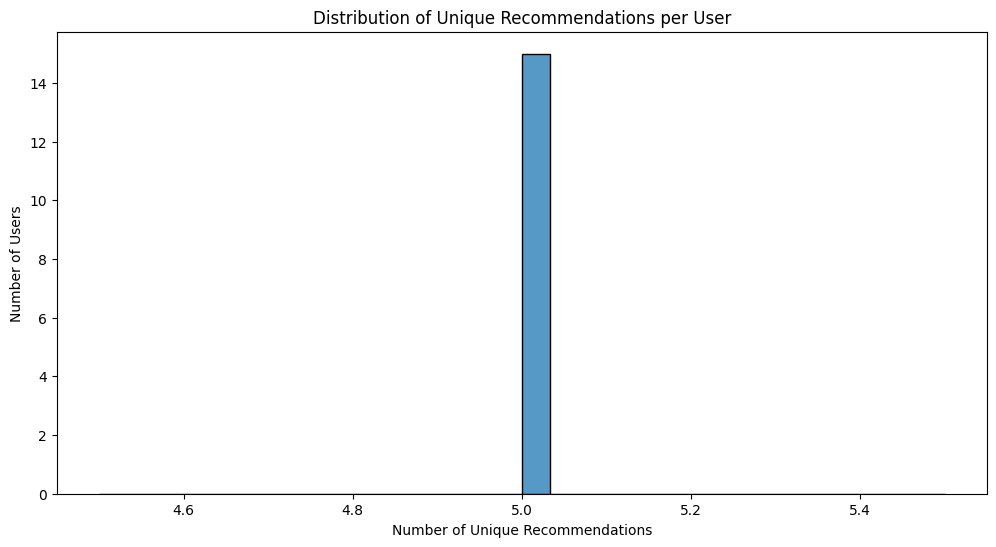

In [22]:
# Create a pivot table for recommendations
pivot_table = recommendations_df.melt(id_vars=['User_ID'], var_name='Recommendation', value_name='Post_ID')
pivot_table.head()

# Plot the number of unique recommendations for each user
unique_recommendations = pivot_table.groupby('User_ID')['Post_ID'].nunique()
plt.figure(figsize=(12, 6))
sns.histplot(unique_recommendations, kde=False, bins=30)
plt.xlabel('Number of Unique Recommendations')
plt.ylabel('Number of Users')
plt.title('Distribution of Unique Recommendations per User')
plt.show()


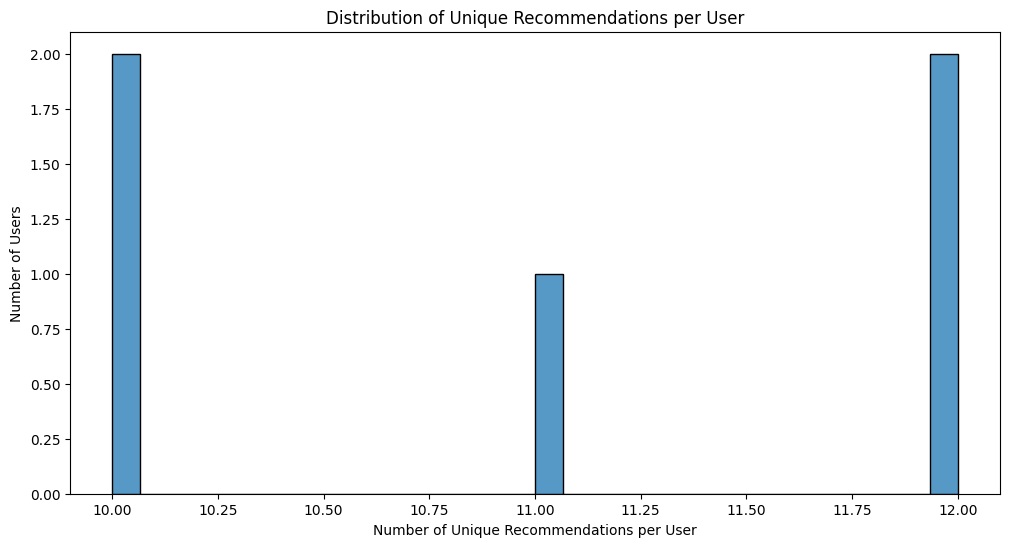

Recommendations for user 669c0b8e2ea43ac3b0c83bd2: ['6701a1a1a1a1a1a1a1a1a1a1', '6701a1a1a1a1a1a1a1a1a1a3', '6701a1a1a1a1a1a1a1a1a1a8', '6701a1a1a1a1a1a1a1a1a1c2', '6701a1a1a1a1a1a1a1a1a1a4']
Recommendations for user 669c0bb23cfd9ea81c694fc8: ['6701a1a1a1a1a1a1a1a1a1c0', '6701a1a1a1a1a1a1a1a1a1c4', '6701a1a1a1a1a1a1a1a1a1a3', '6701a1a1a1a1a1a1a1a1a1b9', '6701a1a1a1a1a1a1a1a1a1b2']
Recommendations for user 669c0b8e2ea43ac3b0c83bd6: ['6701a1a1a1a1a1a1a1a1a1aa', '6701a1a1a1a1a1a1a1a1a1a4', '6701a1a1a1a1a1a1a1a1a1c2', '6701a1a1a1a1a1a1a1a1a1a8', '6701a1a1a1a1a1a1a1a1a1c5']
Recommendations for user 66a0ae5660cb65cbc9feb870: ['6701a1a1a1a1a1a1a1a1a1b1', '6701a1a1a1a1a1a1a1a1a1ac', '6701a1a1a1a1a1a1a1a1a1c6', '6701a1a1a1a1a1a1a1a1a1a6', '66a3ce097a4bf8d54fbcaf48']
Recommendations for user 669c0b8e2ea43ac3b0c83bd3: ['6701a1a1a1a1a1a1a1a1a1ae', '6701a1a1a1a1a1a1a1a1a1aa', '6701a1a1a1a1a1a1a1a1a1bd', '6701a1a1a1a1a1a1a1a1a1a4', '6701a1a1a1a1a1a1a1a1a1a9']


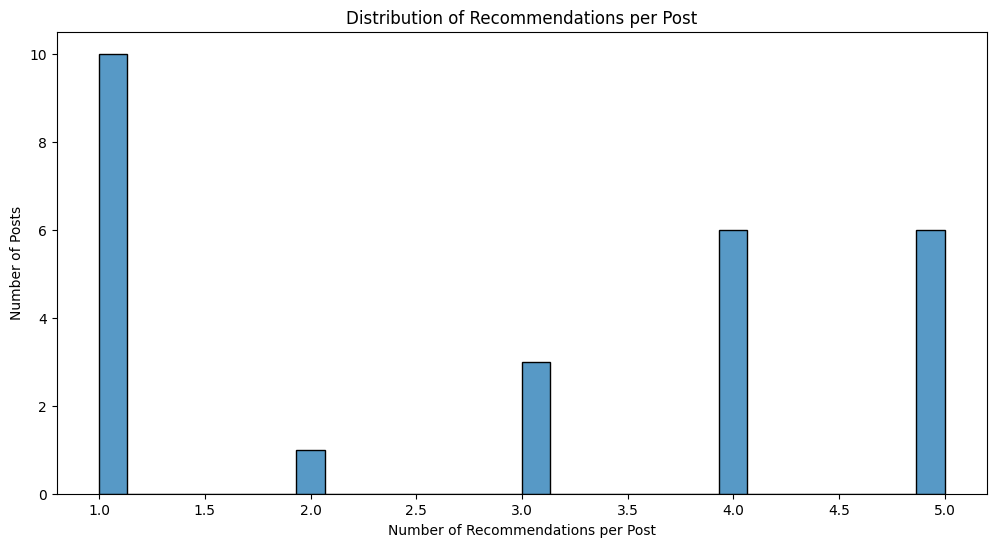

In [23]:
# Analyze recommendation diversity
recommendations_df = pd.read_json('recommendations.json')

# Count the number of unique posts recommended to users
unique_recommendations_count = recommendations_df.apply(lambda x: len(set(x)), axis=1)

plt.figure(figsize=(12, 6))
sns.histplot(unique_recommendations_count, kde=False, bins=30)
plt.xlabel('Number of Unique Recommendations per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Unique Recommendations per User')
plt.show()

# Review recommendations for a few specific users
user_sample = random.sample(list(recommendations.keys()), 5)
for user_id in user_sample:
    print(f"Recommendations for user {user_id}: {recommendations[user_id]}")

# Analyze post popularity in recommendations
all_recommendations = recommendations_df.values.flatten()
post_counts = pd.Series(all_recommendations).value_counts()

plt.figure(figsize=(12, 6))
sns.histplot(post_counts, bins=30, kde=False)
plt.xlabel('Number of Recommendations per Post')
plt.ylabel('Number of Posts')
plt.title('Distribution of Recommendations per Post')
plt.show()
